In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve

In [9]:
df = pd.read_csv('airbnb_data.csv')

C:\Users\Vito\AppData\Local\Temp\ipykernel_17152\3880123708.py:1: DtypeWarning: Columns (17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('airbnb_data.csv')


In [10]:
df.head()

id                                          name  host_id host_name  \
0  21853.0                          Bright and airy room    83531     Abdel   
1  30320.0                   Great Vacational Apartments   130907      Dana   
2  30959.0               Beautiful loft in Madrid Center   132883    Angela   
3  40916.0               Holiday Apartment Madrid Center   130907      Dana   
4  62423.0  MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID   303845    Arturo   

     city neighbourhood  latitude  longitude        room_type  price  \
0  Madrid      Cármenes  40.40381   -3.74130     Private room   31.0   
1  Madrid           Sol  40.41476   -3.70418  Entire home/apt    NaN   
2  Madrid   Embajadores  40.41259   -3.70105  Entire home/apt    NaN   
3  Madrid   Universidad  40.42247   -3.70577  Entire home/apt    NaN   
4  Madrid      Justicia  40.41884   -3.69655     Private room   69.0   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0               4                 33   7/15/2018               0.27   
1               5                172   9/26/2022               0.98   
2               3                  8   5/30/2017               0.07   
3               5                 49  12/11/2021               0.29   
4               1                219  11/24/2024               2.73   

   calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
0                               2             144.0                      0   
1                               3               0.0                      0   
2                               1               0.0                      0   
3                               3               0.0                      0   
4                               3             332.0                     44   

  license Unnamed: 18 Unnamed: 19  
0     NaN         NaN         NaN  
1     NaN         NaN         NaN  
2     NaN         NaN         NaN  
3     NaN         NaN         NaN  
4     NaN         NaN         NaN

In [11]:
df.tail()

id                                            name  \
480468  1.310000e+18                                      open space   
480469  1.310000e+18                       Appartamento zona rustica   
480470  1.310000e+18                                  Trionfale Home   
480471  1.310000e+18  Elegant and high-end stay in the heart of Rome   
480472  1.310000e+18              Charming 3BR flat near the Vatican   

          host_id host_name  city            neighbourhood   latitude  \
480468  594266240     Lucia  Rome         I Centro Storico  41.894188   
480469  539719814     Mirko  Rome  V Prenestino/Centocelle  41.905784   
480470  666388757  Flaminia  Rome         I Centro Storico  41.914105   
480471    7473669      Sara  Rome         I Centro Storico  41.904328   
480472   18593362   Hintown  Rome         I Centro Storico  41.909012   

        longitude        room_type   price  minimum_nights  number_of_reviews  \
480468  12.491580  Entire home/apt    62.0               1                  0   
480469  12.610857  Entire home/apt   100.0               1                  0   
480470  12.450181  Entire home/apt   130.0               1                  0   
480471  12.483495  Entire home/apt  1170.0               3                  0   
480472  12.459523  Entire home/apt   181.0               2                  0   

       last_review  reviews_per_month  calculated_host_listings_count  \
480468         NaN                NaN                               1   
480469         NaN                NaN                               1   
480470         NaN                NaN                               1   
480471         NaN                NaN                              15   
480472         NaN                NaN                               3   

        availability_365  number_of_reviews_ltm             license  \
480468             341.0                      0                 NaN   
480469             365.0                      0                 NaN   
480470             361.0                      0  IT058091C28D6U98ZX   
480471             243.0                      0                 NaN   
480472             356.0                      0                 NaN   

       Unnamed: 18 Unnamed: 19  
480468         NaN         NaN  
480469         NaN         NaN  
480470         NaN         NaN  
480471         NaN         NaN  
480472         NaN         NaN

In [12]:
df.columns = df.columns.str.strip().str.lower() 

df = df.drop(columns=['unnamed: 18', 'unnamed: 19', 'number_of_reviews'])

df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

current_day = pd.Timestamp('2025-02-01')
df['last_review'] = (current_day - df['last_review']).dt.days
df = df.rename(columns={'last_review': 'days_since_last_review','name' : 'description'})

df = df.dropna(subset=['days_since_last_review', 'host_name', 'reviews_per_month'])

df[['city', 'neighbourhood', 'host_name','description']] = df[['city', 'neighbourhood', 'host_name','description']].apply(lambda x: x.str.title())

df = df.astype({'latitude' : 'float' , 'longitude' : 'float' , 'host_id':'int','id' : 'float','calculated_host_listings_count':'int',
                'availability_365' : 'int' , 'days_since_last_review' : 'int' , 'reviews_per_month' : 'float',
                'minimum_nights':'int' , 'price':'float'})

df.license = np.where(df.license.isna(), 0, 1)
df = df.drop_duplicates()

df = df.reset_index(drop=True)

df = df[df['price'] >= 10] 
df = df[df['price'] < 500]
df = df[df['reviews_per_month'] >= 1]
df = df[df['days_since_last_review'] <= 365]
df = df[df['minimum_nights'] <= 10]

df.reset_index(drop=True, inplace=True)
df = shuffle(df, random_state=42).reset_index(drop=True)

In [13]:
df_parametrics = pd.DataFrame({'Dtypes' : df.dtypes,
                              'Nunique' : df.nunique(),
                              'Missing':df.isnull().sum()})
df_parametrics

Dtypes  Nunique  Missing
id                              float64    49710        0
description                      object   131768        0
host_id                           int32    78176        0
host_name                        object    20451        0
city                             object       20        0
neighbourhood                    object     1263        0
latitude                        float64   104854        0
longitude                       float64   110586        0
room_type                        object        4        0
price                           float64      490        0
minimum_nights                    int32       10        0
days_since_last_review            int32      334        0
reviews_per_month               float64     1309        0
calculated_host_listings_count    int32      160        0
availability_365                  int32      366        0
number_of_reviews_ltm             int64      283        0
license                           int32        2        0

In [14]:
for col in df.columns:
    print(f"--- {col} sütunu ---")
    print(df[col].value_counts())
    print()

--- id sütunu ---
id
1.130000e+18    2061
1.200000e+18    2059
1.210000e+18    2008
1.170000e+18    2000
1.180000e+18    1996
                ... 
2.432800e+07       1
4.487221e+07       1
8.880330e+05       1
2.384675e+07       1
1.860869e+07       1
Name: count, Length: 49710, dtype: int64

--- description sütunu ---
description
Habitación Con Baño Privado                    30
#Name?                                         27
Habitación Individual                          21
Appartement                                    19
Habitación Doble                               17
                                               ..
Bright Apartment In Gran Vía With Balconies     1
Cosy 2 Bed Flat In Zone 1                       1
Richmond Retreat                                1
Artes 3                                         1
Mandruchello'S                                  1
Name: count, Length: 131768, dtype: int64

--- host_id sütunu ---
host_id
291253690    257
377605855    208
23532561 

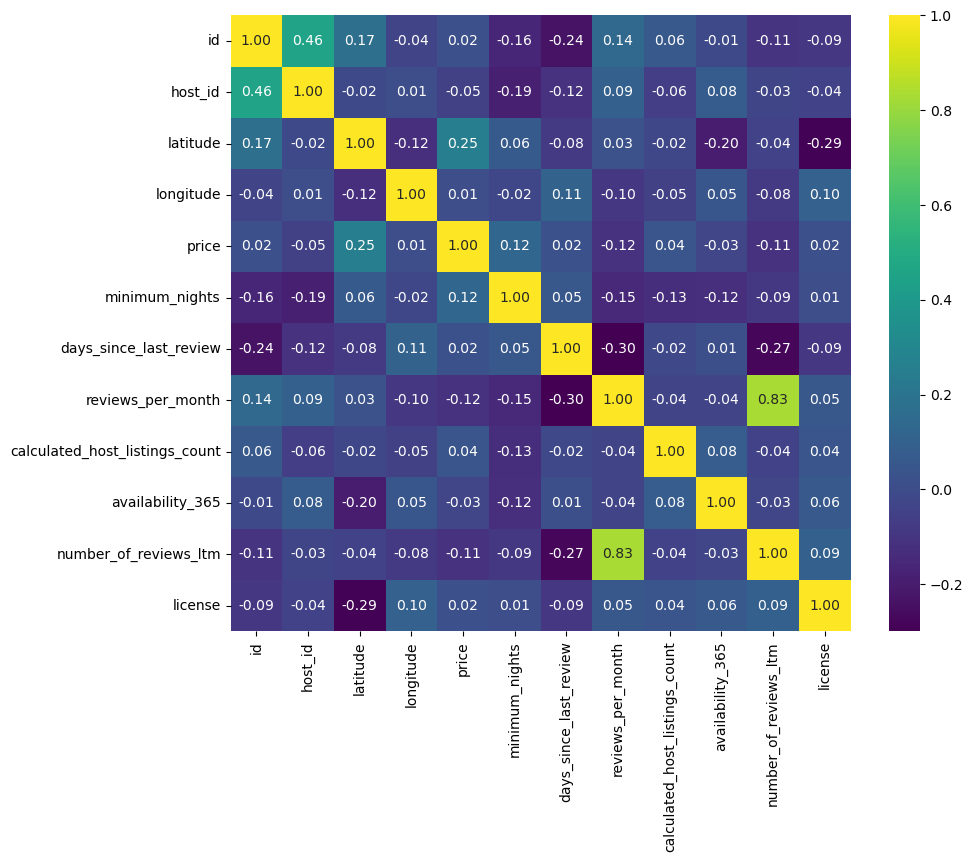

In [9]:
df_corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(df_corr,annot=True,fmt=".2f", cbar=True, cmap="viridis")
plt.show()

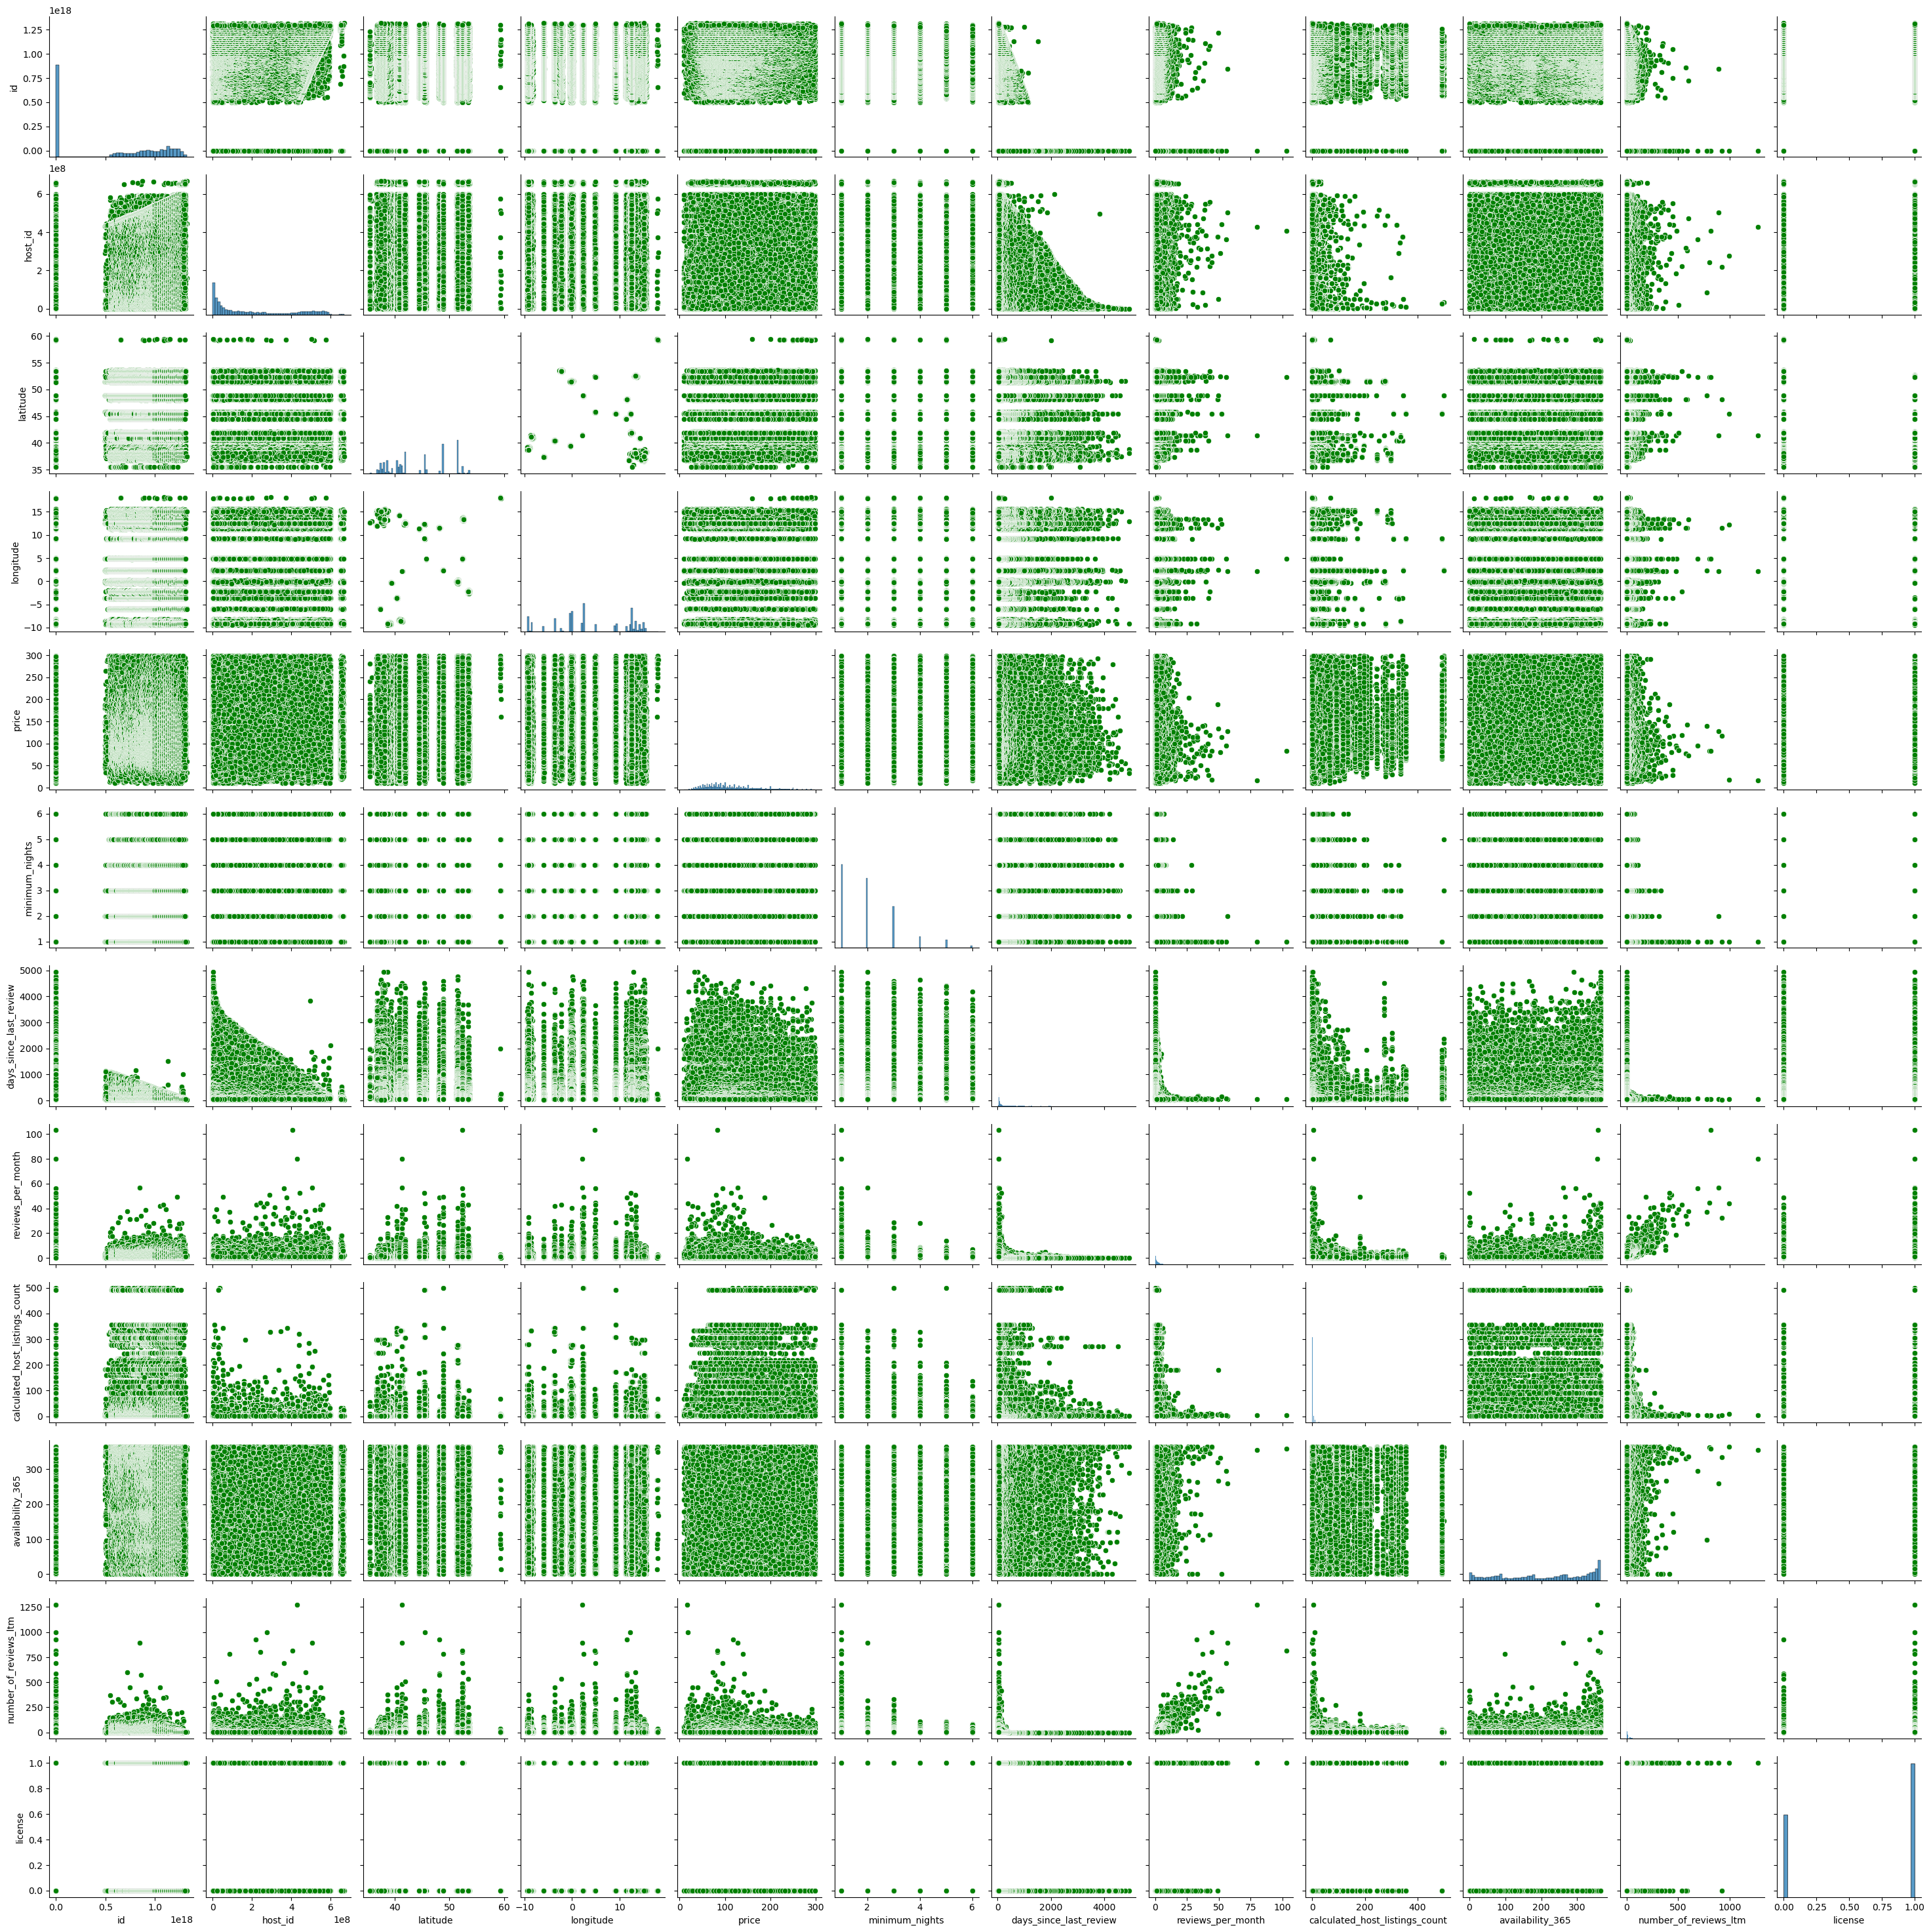

In [10]:
sns.pairplot(df, plot_kws={"color": "green"})
plt.show()

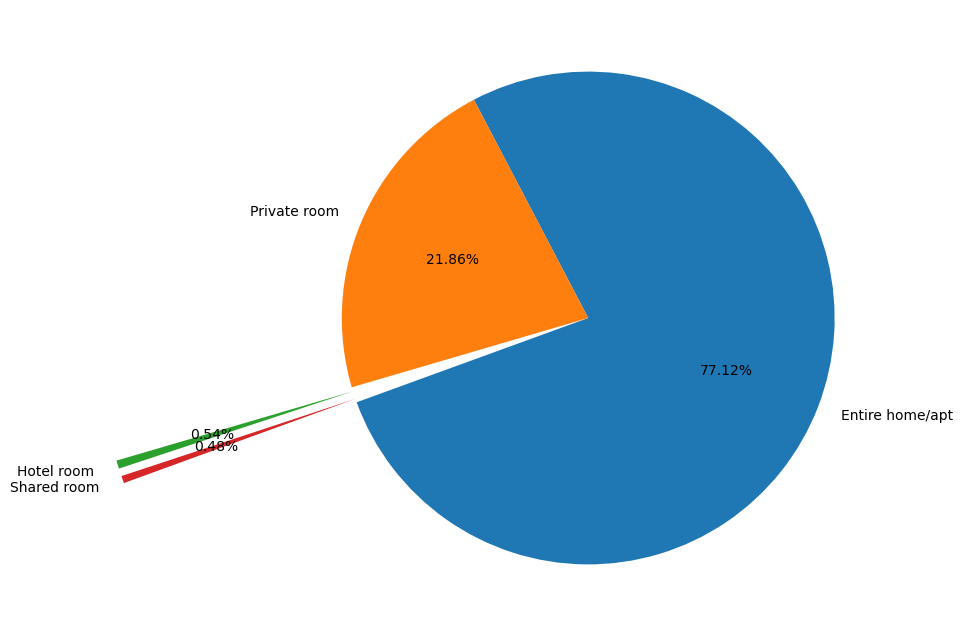

In [11]:
a=df.room_type.value_counts()
explodes = [0,0,1,1]
plt.figure(figsize=(8,8))
plt.pie(a, labels=a.index, autopct="%1.2f%%", 
        startangle=200,explode=explodes)
plt.show()

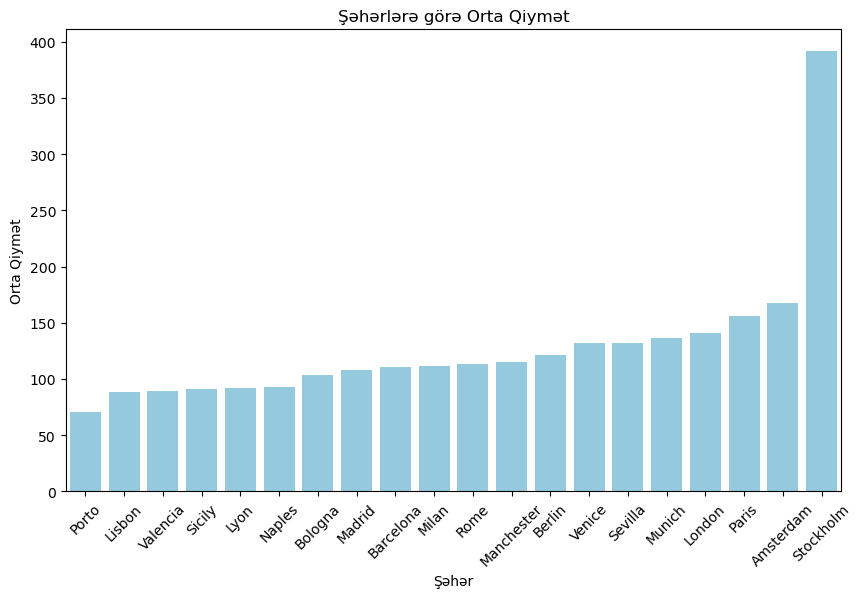

In [26]:
city_prices = df.groupby("city")["price"].mean().sort_values(ascending=True)
plt.figure(figsize=(10,6))
sns.barplot(x=city_prices.index, y=city_prices.values,color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Şəhər")
plt.ylabel("Orta Qiymət")
plt.title("Şəhərlərə görə Orta Qiymət")
plt.show()

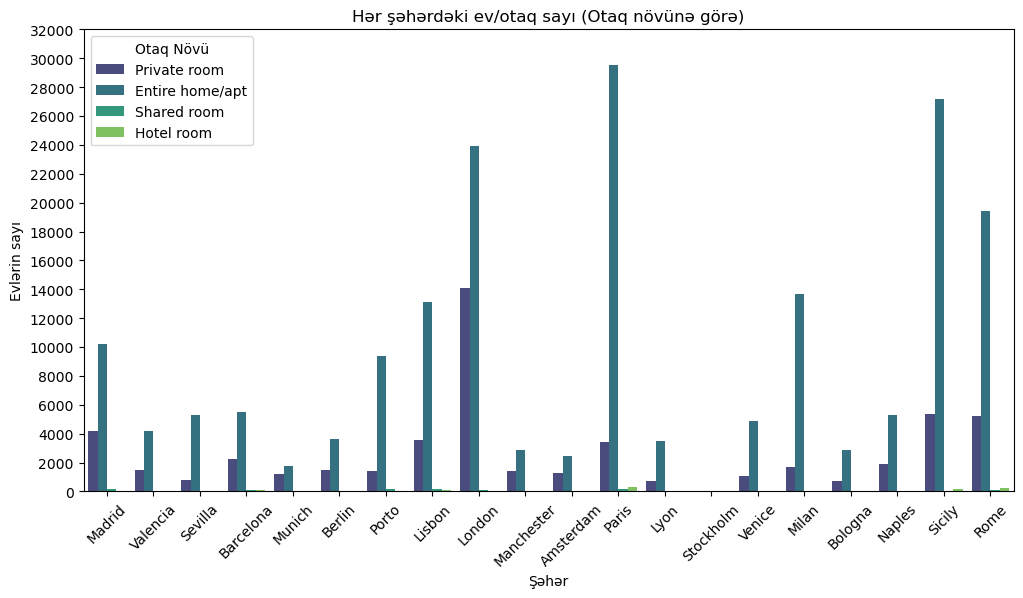

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="city", hue="room_type", palette="viridis")
plt.xlabel("Şəhər")
plt.ylabel("Evlərin sayı")
plt.title("Hər şəhərdəki ev/otaq sayı (Otaq növünə görə)")
plt.xticks(rotation=45)  
plt.yticks(range(0, df["city"].value_counts().max()-5000, 2000))
plt.legend(title="Otaq Növü") 
plt.show()

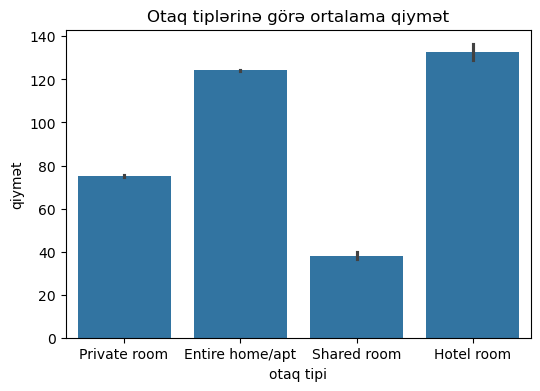

In [14]:
plt.figure(figsize=(6,4))
sns.barplot(df,x='room_type',y='price')
plt.title('Otaq tiplərinə görə ortalama qiymət')
plt.xlabel('otaq tipi')
plt.ylabel('qiymət')
plt.show()

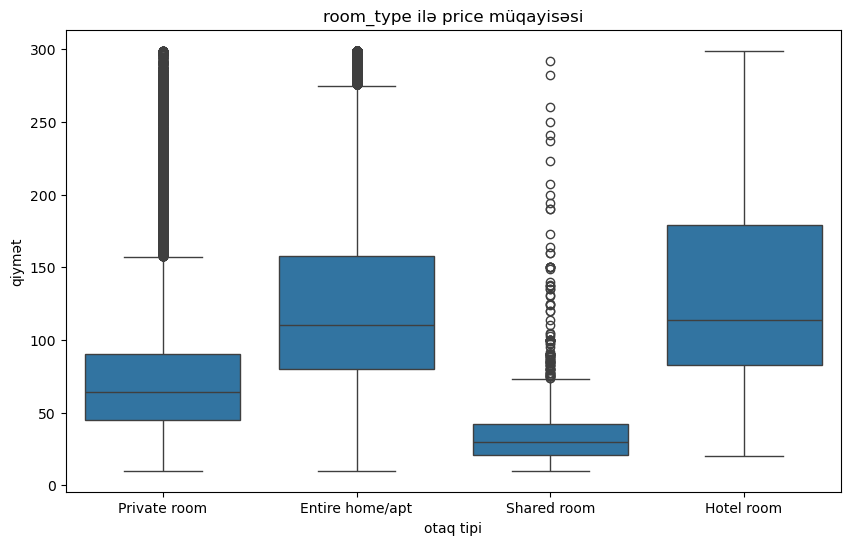

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="room_type", y="price", data=df)
plt.xlabel("otaq tipi")
plt.ylabel("qiymət")
plt.title("room_type ilə price müqayisəsi")
plt.show()

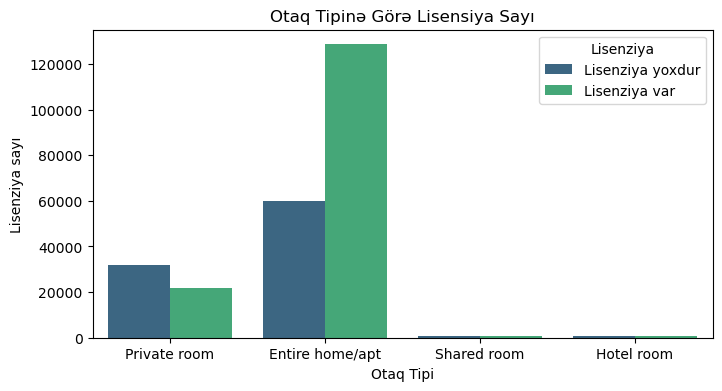

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="room_type", hue="license", palette="viridis")
plt.title("Otaq Tipinə Görə Lisensiya Sayı")
plt.xlabel("Otaq Tipi")
plt.ylabel("Lisenziya sayı")
plt.legend(title="Lisenziya", labels=["Lisenziya yoxdur", "Lisenziya var"])
plt.show()

C:\Users\Vito\AppData\Local\Temp\ipykernel_14444\564113834.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='city', y='minimum_nights', hue='room_type',ci=None)


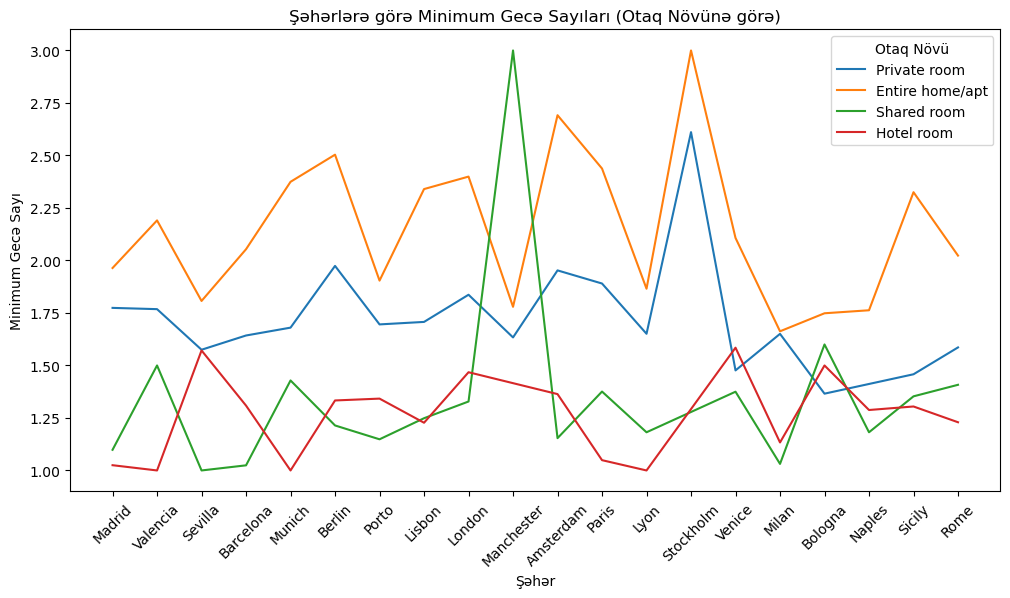

In [17]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='city', y='minimum_nights', hue='room_type',ci=None)

plt.xticks(rotation=45)  
plt.xlabel("Şəhər")
plt.ylabel("Minimum Gecə Sayı")
plt.title("Şəhərlərə görə Minimum Gecə Sayıları (Otaq Növünə görə)")

plt.legend(title="Otaq Növü")  
plt.show()
 

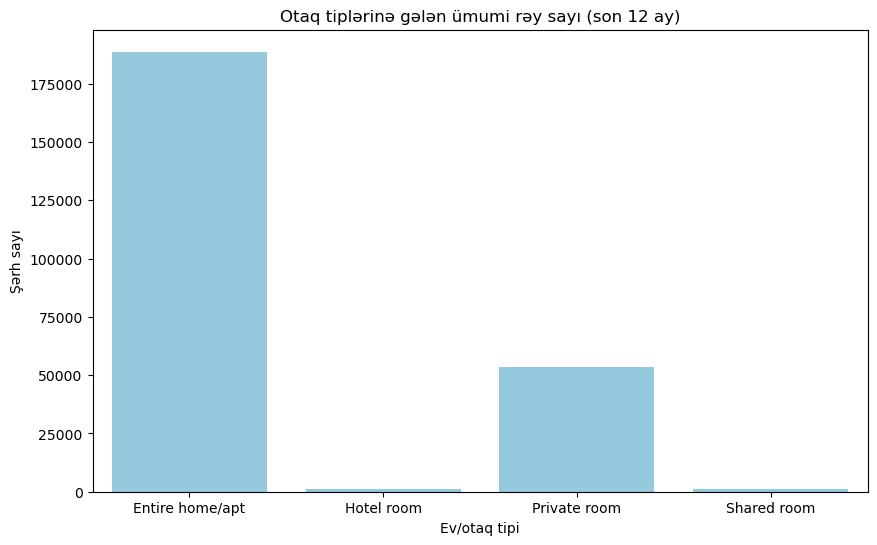

In [46]:
count_of_reviews_for_room_types = df.groupby('room_type')['number_of_reviews_ltm'].count()
plt.figure(figsize=(10,6))
sns.barplot(x=count_of_reviews_for_room_types.index, y=count_of_reviews_for_room_types.values,color='skyblue')
plt.xlabel("Ev/otaq tipi")
plt.ylabel("Şərh sayı")
plt.title("Otaq tiplərinə gələn ümumi rəy sayı (son 12 ay)")
plt.show()

C:\Users\Vito\AppData\Local\Temp\ipykernel_14444\2695432217.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="room_type", y="number_of_reviews_ltm", estimator=np.mean, palette="viridis", ci=None)
C:\Users\Vito\AppData\Local\Temp\ipykernel_14444\2695432217.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="room_type", y="number_of_reviews_ltm", estimator=np.mean, palette="viridis", ci=None)


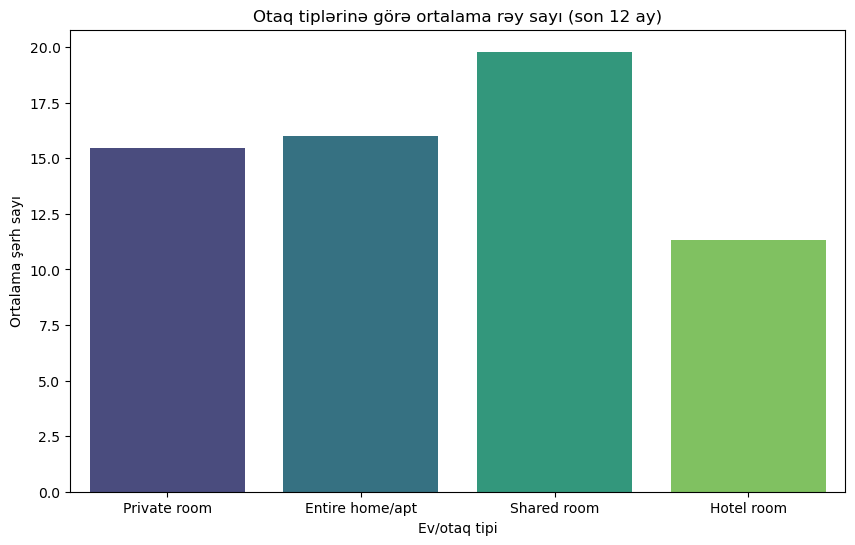

In [19]:
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="room_type", y="number_of_reviews_ltm", estimator=np.mean, palette="viridis", ci=None)
plt.xlabel("Ev/otaq tipi")
plt.ylabel("Ortalama şərh sayı")
plt.title("Otaq tiplərinə görə ortalama rəy sayı (son 12 ay)")
plt.show()

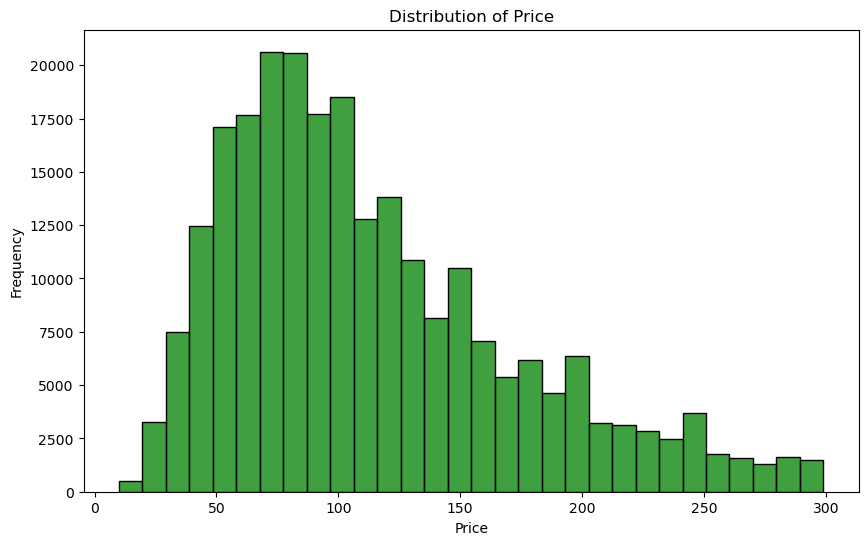

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], bins=30, color="green")

plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

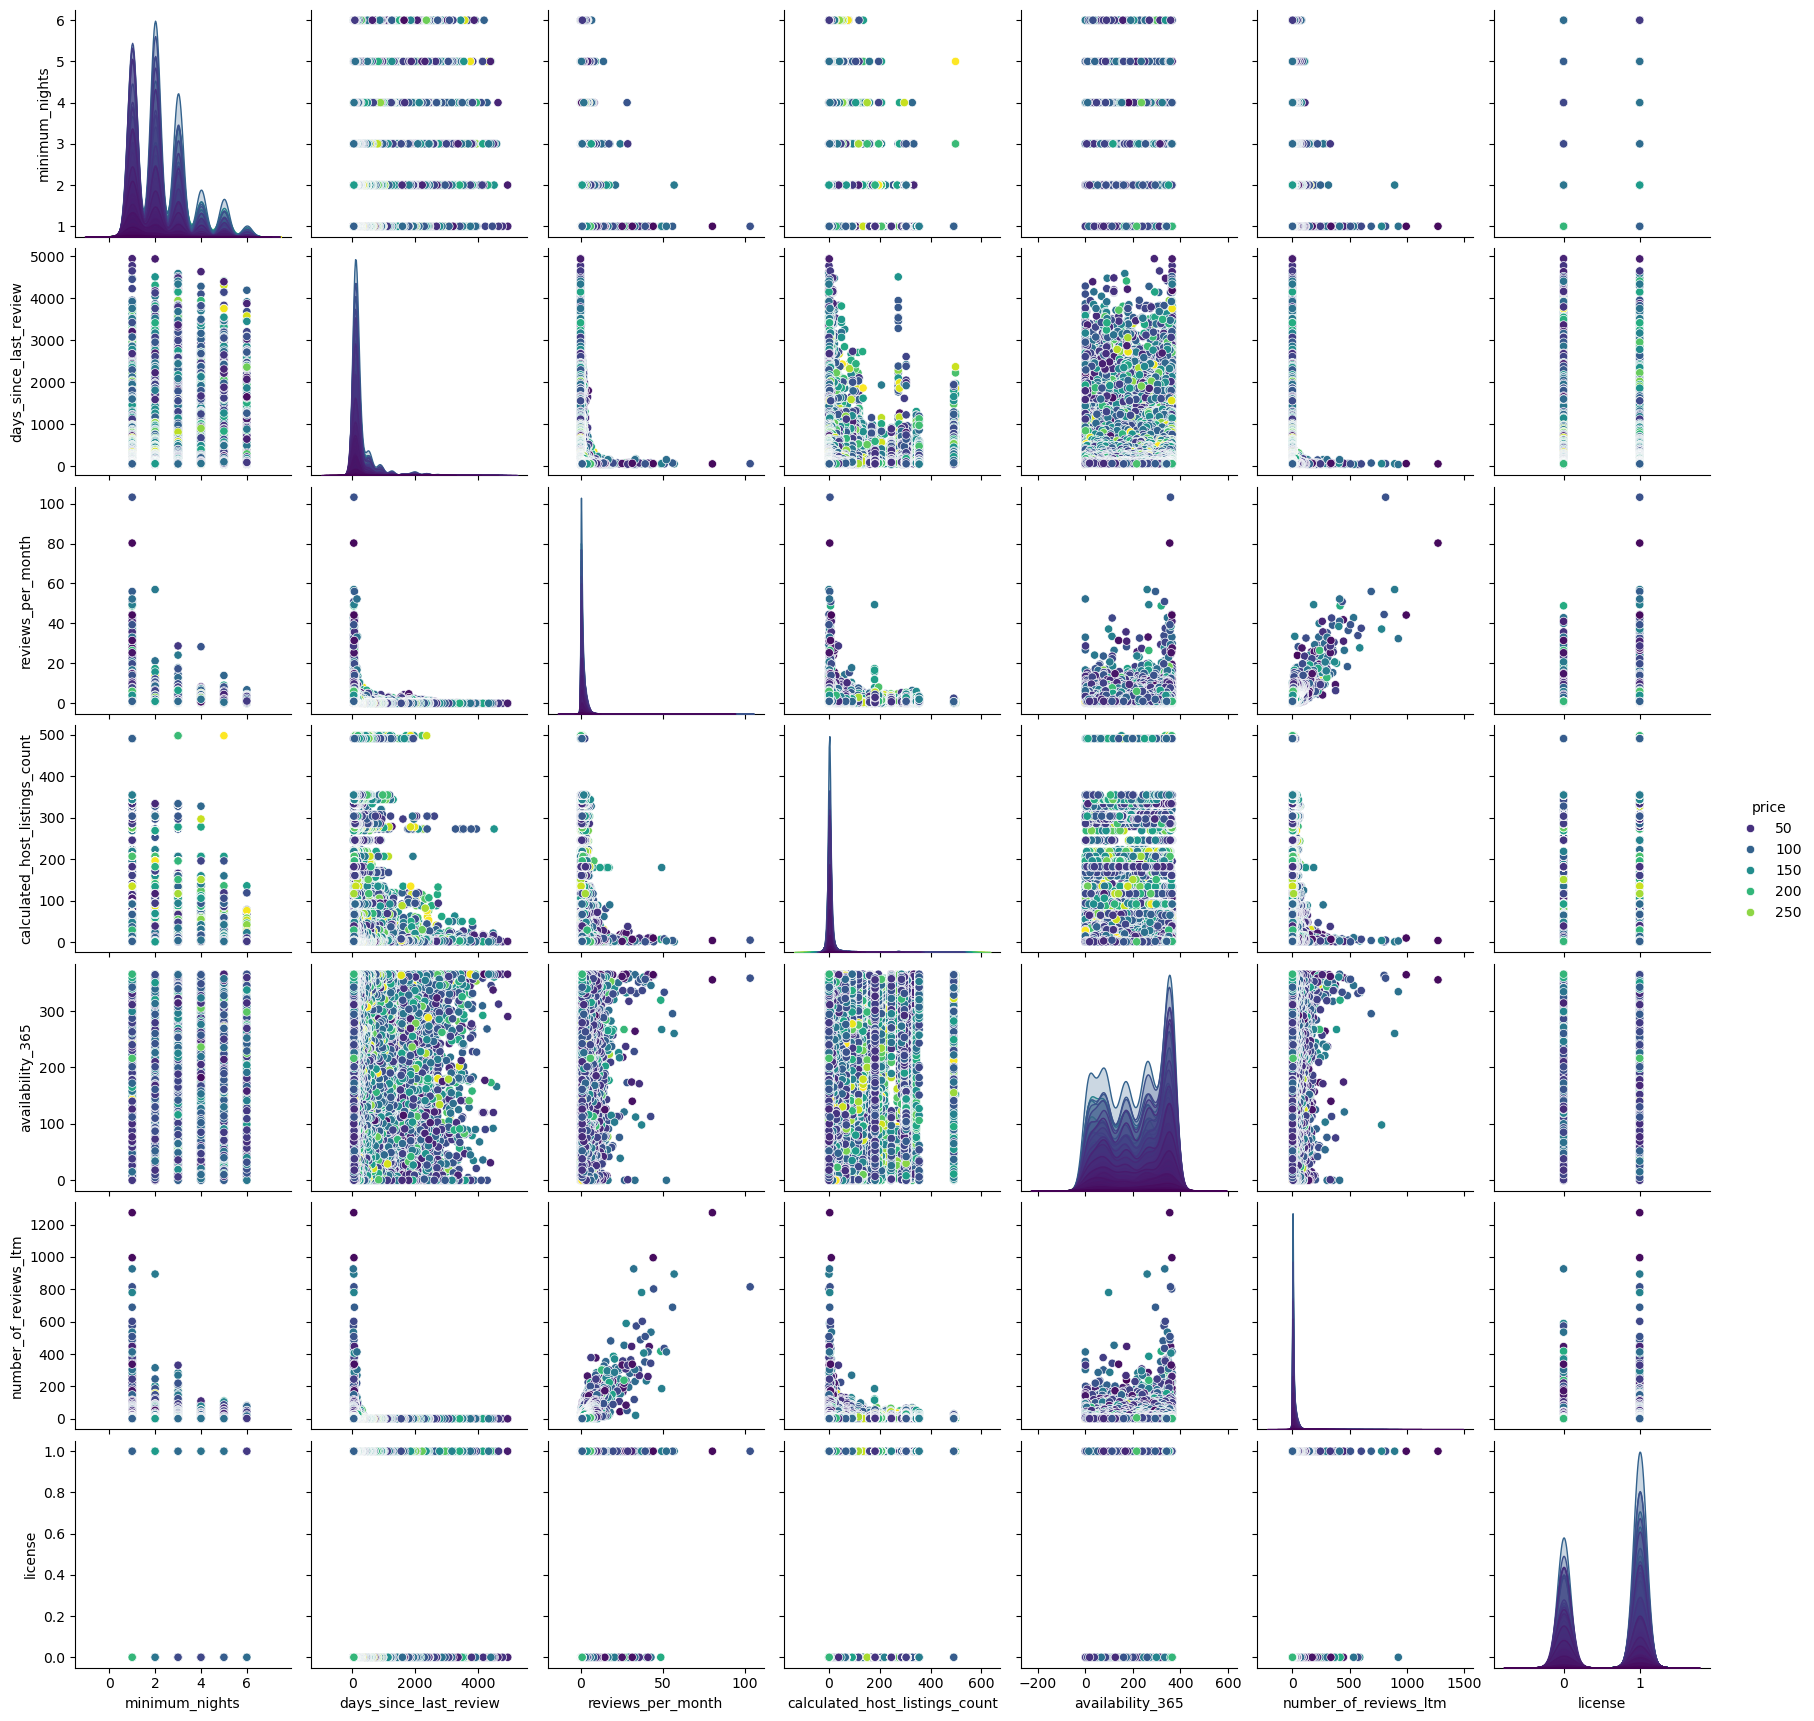

In [21]:
sns.pairplot(df, vars=['minimum_nights','days_since_last_review','reviews_per_month','calculated_host_listings_count', 'availability_365',
'number_of_reviews_ltm', 'license'], hue='price', palette="viridis")
plt.show()

In [15]:
df_ = df

df_ = pd.get_dummies(df_, columns=['room_type', 'city'], drop_first=True)
freq = df_['neighbourhood'].value_counts()
df_['neighbourhood'] = df_['neighbourhood'].map(freq)
df_ = df_.drop(columns=['id','description','host_id','host_name'])

In [46]:
# Linear Regression For Price

X = df_.drop(columns='price')
y = df_.price
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=100)
regression_model  = lr()
regression_model.fit(X_train,y_train)
y_train_pred = regression_model.predict(X_train)
y_test_pred = regression_model.predict(X_test)

mse_train_lr_price = (mean_squared_error(y_train, y_train_pred))
mse_test_lr_price = (mean_squared_error(y_test, y_test_pred))
mae_train_lr_price = (mean_absolute_error(y_train, y_train_pred))
mae_test_lr_price = (mean_absolute_error(y_test, y_test_pred))
r2_train_lr_price = (r2_score(y_train, y_train_pred))
r2_test_lr_price = (r2_score(y_test, y_test_pred))
                    
print ("MSE train: " ,mse_train_lr_price,'\n',
       "MSE test : " , mse_test_lr_price,'\n',
      "MAE train: " ,mae_train_lr_price,'\n',
      "MAE test: " ,mae_test_lr_price,'\n',
      "R2 train: " ,r2_train_lr_price,'\n',
      "R2 test: " ,r2_test_lr_price)


MSE train:  693010.4997141211 
 MSE test :  4544942.475043304 
 MAE train:  143.5534123762051 
 MAE test:  146.13927753810518 
 R2 train:  0.0007298095471065524 
 R2 test:  0.00020996377631143925


In [47]:
# Decision Tree Regressor For Price

X = df_.drop(columns='price')
y = df_.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {
    "max_depth": [5, 10, 15],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4],
    "max_features": ["sqrt"]}

grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
train_pred = best_dt.predict(X_train)
test_pred = best_dt.predict(X_test)

mse_train_dt_price = mean_squared_error(y_train, train_pred)
mse_test_dt_price = mean_squared_error(y_test, test_pred)
mae_train_dt_price = mean_absolute_error(y_train, train_pred)
mae_test_dt_price = mean_absolute_error(y_test, test_pred)
r2_train_dt_price = r2_score(y_train, train_pred)
r2_test_dt_price = r2_score(y_test, test_pred)

print("Best Params:", grid_dt.best_params_)
print("MSE Train:", mse_train_dt_price)
print("MSE Test:", mse_test_dt_price)
print("MAE Train:", mae_train_dt_price)
print("MAE Test:",mae_test_dt_price)
print("R² Train:", r2_train_dt_price)
print("R² Test:", r2_test_dt_price)

Best Params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}
MSE Train: 1108119.5707436628
MSE Test: 384828.1729580179
MAE Train: 104.26877806248562
MAE Test: 111.70615398959416
R² Train: 0.3601628320802627
R² Test: 0.019389384696706813


In [48]:
#Random Forest for Price
X = df_.drop("price", axis=1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse_train_rf_price = mean_squared_error(y_train, train_pred)
mse_test_rf_price = mean_squared_error(y_test, test_pred)
mae_train_rf_price = mean_absolute_error(y_train, train_pred)
mae_test_rf_price = mean_absolute_error(y_test, test_pred)
r2_train_rf_price = r2_score(y_train, train_pred)
r2_test_rf_price = r2_score(y_test, test_pred)

print("MSE Train:", mse_train_rf_price)
print("MSE Test:", mse_test_rf_price)
print("MAE Train:", mae_train_rf_price)
print("MAE Test:", mae_test_rf_price)
print("R² Train:",r2_train_rf_price)
print("R² Test:", r2_test_rf_price)

MSE Train: 1108119.5707436628
MSE Test: 384828.1729580179
MAE Train: 104.26877806248562
MAE Test: 111.70615398959416
R² Train: 0.3601628320802627
R² Test: 0.019389384696706813


In [50]:
#LightGBM Classifier for Price
X = df_.drop(columns="price")
y = df_["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train_p, y_train_p)

mse_train_lgbm_price = mean_squared_error(y_train_p, train_pred_p)
mse_test_lgbm_price = mean_squared_error(y_test_p, test_pred_p)
mae_train_lgbm_price = mean_absolute_error(y_train_p, train_pred_p)
mae_test_lgbm_price = mean_absolute_error(y_test_p, test_pred_p)
r2_train_lgbm_price = r2_score(y_train_p, train_pred_p)
r2_test_lgbm_price = r2_score(y_test_p, test_pred_p)

print("MSE Train:", mse_train_lgbm_price)
print("MSE Test:", mse_test_lgbm_price)
print("MAE Train:", mae_train_lgbm_price)
print("MAE Test:", mae_test_lgbm_price)
print("R² Train:", r2_train_lgbm_price)
print("R² Test:", r2_test_lgbm_price)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 235907, number of used features: 33
[LightGBM] [Info] Start training from score 187.033649
MSE Train: 220825.05451277853
MSE Test: 376209.47292630613
MAE Train: 96.773877448722
MAE Test: 105.01508531205623
R² Train: 0.8724938344060142
R² Test: 0.04135136496506253


In [51]:
# Decision Tree Regressor For License
X = df_.drop(columns='license')
y = df_.license

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {
     "max_depth": [5, 10, 15],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4],
    "max_features": ["sqrt"]
}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5,  n_jobs=-1)
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
train_pred = best_dt.predict(X_train)
test_pred = best_dt.predict(X_test)

mse_train_dt_license = mean_squared_error(y_train, train_pred)
mse_test_dt_license = mean_squared_error(y_test, test_pred)
mae_train_dt_license = mean_absolute_error(y_train, train_pred)
mae_test_dt_license = mean_absolute_error(y_test, test_pred)
r2_train_dt_license = r2_score(y_train, train_pred)
r2_test_dt_license = r2_score(y_test, test_pred)

print("Best Params:", grid_dt.best_params_)
print("MSE Train:", mse_train_dt_license)
print("MSE Test:",mse_test_dt_license)
print("MAE Train:", mae_train_dt_license)
print("MAE Test:", mae_test_dt_license)
print("R² Train:",r2_train_dt_license)
print("R² Test:", r2_test_dt_license)

Best Params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
MSE Train: 0.08857421628761444
MSE Test: 0.09074747960476919
MAE Train: 0.17714843257522891
MAE Test: 0.17927744259058961
R² Train: 0.6318202452111827
R² Test: 0.6223053342993892


In [52]:
#Random Forest Regressor For License
X = df_.drop(columns='license')
y = df_.license

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse_train_rf_license = mean_squared_error(y_train, train_pred)
mse_test_rf_license = mean_squared_error(y_test, test_pred)
mae_train_rf_license = mean_absolute_error(y_train, train_pred)
mae_test_rf_license = mean_absolute_error(y_test, test_pred)
r2_train_rf_license = r2_score(y_train, train_pred)
r2_test_rf_license = r2_score(y_test, test_pred)

print("MSE Train:", mse_train_rf_license)
print("MSE Test:", mse_test_rf_license)
print("MAE Train:", mae_train_rf_license)
print("MAE Test:", mae_test_rf_license)
print("R² Train:", r2_train_rf_license)
print("R² Test:", r2_test_rf_license)

MSE Train: 0.08857421628761444
MSE Test: 0.09074747960476919
MAE Train: 0.17714843257522891
MAE Test: 0.17927744259058961
R² Train: 0.6318202452111827
R² Test: 0.6223053342993892


In [53]:
# Logistic Regression for License
X = df_.drop(columns="license")
y = df_["license"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

acc_train_log_license = accuracy_score(y_train, y_pred_train)
acc_test_log_license = accuracy_score(y_test, y_pred_test)
recall_train_log_license = recall_score(y_train, y_pred_train)
recall_test_log_license = recall_score(y_test, y_pred_test)
f1_train_log_license = f1_score(y_train, y_pred_train)
f1_test_log_license = f1_score(y_test, y_pred_test)

print(confusion_matrix(y_test, y_pred_test))
print("Accuracy Train:", acc_train_log_license)
print("Accuracy Test:", acc_test_log_license)
print("Recall Train:", recall_train_log_license)
print("Recall Test:", recall_test_log_license)
print("F1 Train:", f1_train_log_license)
print("F1 Test:", f1_test_log_license)

[[    0 23670]
 [    0 35307]]
Accuracy Train: 0.5970912266274422
Accuracy Test: 0.5986571036166641
Recall Train: 1.0
Recall Test: 1.0
F1 Train: 0.7477233819489603
F1 Test: 0.7489499809087438


In [55]:
# Lgbm for license
X = df_.drop(columns="license")
y = df_["license"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(X_train, y_train)

y_pred_train = lgb_clf.predict(X_train)
y_pred_test = lgb_clf.predict(X_test)

acc_train_lgbm_license = accuracy_score(y_train, y_pred_train)
acc_test_lgbm_license = accuracy_score(y_test, y_pred_test)
recall_train_lgbm_license = recall_score(y_train, y_pred_train)
recall_test_lgbm_license = recall_score(y_test, y_pred_test)
f1_train_lgbm_license = f1_score(y_train, y_pred_train)
f1_test_lgbm_license = f1_score(y_test, y_pred_test)

print(confusion_matrix(y_test, y_pred_test))
print("Accuracy Train:", acc_train_lgbm_license)
print("Accuracy Test:", acc_test_lgbm_license)
print("Recall Train:", recall_train_lgbm_license)
print("Recall Test:", recall_test_lgbm_license)
print("F1 Train:", f1_train_lgbm_license)
print("F1 Test:", f1_test_lgbm_license)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 140858, number of negative: 95049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 235907, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.597091 -> initscore=0.393360
[LightGBM] [Info] Start training from score 0.393360
[[19165  4505]
 [ 1663 33644]]
Accuracy Train: 0.8966457120814558
Accuracy Test: 0.8954168574189938
Recall Train: 0.9541737068537108
Recall Test: 0.9528988585832837
F1 Train: 0.9168383426333956
F1 Test: 0.9160313657155303


In [39]:
#XGBOOST FOR PRICE
X = df.drop(columns='price')
y = np.log1p(df['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost modelini qururuq
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [1400],          
    'max_depth': [7],                
    'learning_rate': [0.05],           
    'subsample': [0.8],               
    'colsample_bytree': [1.0],         
    'gamma': [1],                       
    'reg_alpha': [0],                    
    'reg_lambda': [1]                     
}


grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=10, scoring='r2', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Ən yaxşı parametrlər:", grid_search.best_params_)

best_model = grid_search.best_estimator_
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

print("MSE Train:", round(mean_squared_error(y_train, train_pred), 5))
print("MSE Test:", round(mean_squared_error(y_test, test_pred), 5))
print("MAE Train:", round(mean_absolute_error(y_train, train_pred), 5))
print("MAE Test:", round(mean_absolute_error(y_test, test_pred), 5))
print("R² Train:", round(r2_score(y_train, train_pred), 5))
print("R² Test:", round(r2_score(y_test, test_pred), 5))


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Ən yaxşı parametrlər: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1400, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
MSE Train: 0.14729
MSE Test: 0.15859
MAE Train: 0.29804
MAE Test: 0.31015
R² Train: 0.56639
R² Test: 0.53433


Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\Vito\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ən yaxşı parametrlər: {'max_depth': 5, 'n_estimators': 206}
Ən yaxşı qiymət (F1): 0.9375802288918982


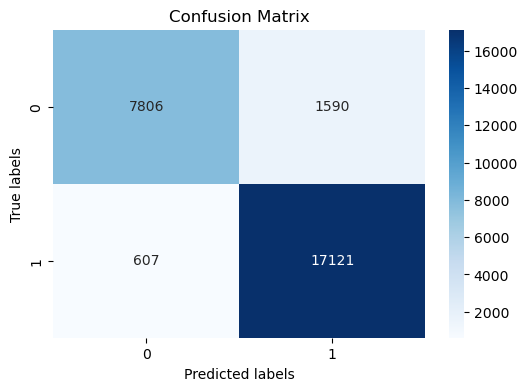

[[ 7806  1590]
 [  607 17121]]
Accuracy Train: 0.93155
Accuracy Test: 0.919
Recall Train: 0.97456
Recall Test: 0.96576
F1 Train: 0.94866
F1 Test: 0.93971
ROC AUC Train: 0.98095
ROC AUC Test: 0.96708


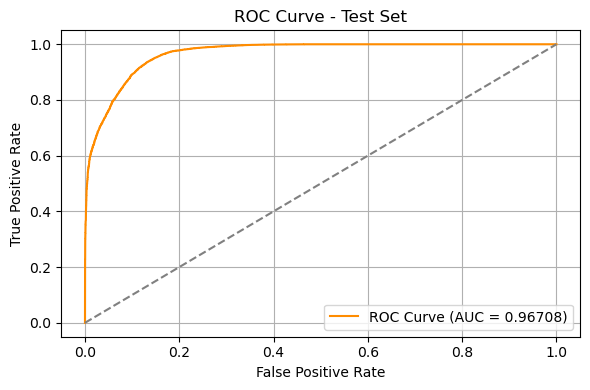

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import xgboost as xgb

# X və y
X = df_.drop(columns='license')
y = df_['license']

# Train-test bölməsi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Parametr paylanmaları
param_grid = {
    'n_estimators': [206],
    'max_depth': [5]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=10,
    verbose=1,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Ən yaxşı model və nəticələr
print("Ən yaxşı parametrlər:", grid_search.best_params_)
print("Ən yaxşı qiymət (F1):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Qiymətləndirmə
acc_train = round(accuracy_score(y_train, y_pred_train), 5)
acc_test = round(accuracy_score(y_test, y_pred_test), 5)
recall_train = round(recall_score(y_train, y_pred_train), 5)
recall_test = round(recall_score(y_test, y_pred_test), 5)
f1_train = round(f1_score(y_train, y_pred_train), 5)
f1_test = round(f1_score(y_test, y_pred_test), 5)

# Confusion matrix-i hesablayırsınız
cm = confusion_matrix(y_test, y_pred_test)

# Heatmap ilə vizuallaşdırırsınız
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC üçün ehtimallar
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

# ROC AUC dəyərləri
roc_auc_train = round(roc_auc_score(y_train, y_pred_proba_train), 5)
roc_auc_test = round(roc_auc_score(y_test, y_pred_proba_test), 5)

# Çap
print(confusion_matrix(y_test, y_pred_test))
print("Accuracy Train:", acc_train)
print("Accuracy Test:", acc_test)
print("Recall Train:", recall_train)
print("Recall Test:", recall_test)
print("F1 Train:", f1_train)
print("F1 Test:", f1_test)
print("ROC AUC Train:", roc_auc_train)
print("ROC AUC Test:", roc_auc_test)

# ROC əyrisi (test üçün)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_test})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
